In [1]:
import numpy as np
import pandas as pd

In [2]:
# upload the csv file
df1 = pd.read_csv('RS126_to.csv')

# drop unnecessary columns
#df1= df1.drop(columns=['dssp3','disorder','cb513_mask'])

### Remove Unequal-Length Rows from Existing CSV
df = df1[df1['input'].str.len() == df1['dssp3'].str.len()]

removed = len(df1) - len(df)
print(f"Cleaned DataFrame created. Removed {removed} mismatched entries.")

df.head()

Cleaned DataFrame created. Removed 1 mismatched entries.


,input,dssp3
0,APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...,CCEEEEECCCCCCCCCEEEEEEECCCCEEEEEEECEECCEECCCCC...
1,CSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNW...,CCEEEECCCCCCCCCCCEECCCCCCEEEEEEECCCCCCCCCCCECC...
2,NVYHDGACPEVKPVDNFDWSNYHGKWWEVAKYPNSVEKYGKCGWAE...,CEEEECCCCCCCCCCCCCHHHCCEEEEEEEECCCCCCCCCEEEEEE...
3,AAPCFCSGKPGRGDLWILRGTCPGGYGYTSNCYKWPNICCYPH,CCCCCCCCCCCCCEEECCCCCCCCCCCCCCEEEECCEEEECCC
4,SISQQTVWNQMATVRTPLNFDSSKQSFCQFSVDLLGGGISVDKTGD...,CCCCCCCCEEEEEEECCCCCCCCCCCEEEEEEECCCCEEECCCCCC...


In [3]:
# Extract the 'input' column as a string
input_sequences = df['input'].astype(str).to_list()
input_sequences_string = (input_sequences)
primary = input_sequences_string

In [4]:
##AS LIST FOR PRIMARY AMINOACID SEQUENCE
#print(primary)
print(len(primary))
## AS STRING
sequence = ', '.join(primary)
#print(sequence)
print(len(sequence))

125
22842


In [5]:
# Extract the 'dssp3' column as a string
dssp3_sequences = df['dssp3'].astype(str).to_list()
dssp3_sequences_string = (dssp3_sequences)
dssp3_structure = dssp3_sequences_string

In [6]:
##AS LIST FOR DSSP8
#print(dssp3_structure)
print(len(dssp3_structure))
## AS STRING
dssp3 = ', '.join(dssp3_structure)
#print(dssp3)
print(len(dssp3))

125
22842


In [7]:
#Standard 20 aminoacids
AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

In [8]:
#Q8 to Q3 mapping
def map_dssp_to_q3(dssp_label):
  if dssp_label in ['H', 'G', 'I']:
    return 'H'
  elif dssp_label in ['E', 'B']:
    return 'E'
  else:
    return 'C'

In [9]:
#Sliding window encoder
from sklearn.preprocessing import OneHotEncoder

def encode_sequence_with_labels(sequence, structure, window_size=15):
  assert len(sequence)== len(structure), "Sequence and structure length mismatch."
  pad = window_size//2
  padded_seq = "X" *pad + sequence + "X" *pad
  encoded_features = []
  labels = []

  #One hot encoder setup

  encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
  encoder.fit(np.array(AMINO_ACIDS + ['X']).reshape(-1,1))
  for i in range(len(sequence)):
    window = padded_seq[i:i+window_size]
    onehot = encoder.transform(np.array(list(window)).reshape(-1,1)).flatten()
    encoded_features.append(onehot)
    labels.append(map_dssp_to_q3(structure[i]))

  return np.array(encoded_features), np.array(labels)

In [10]:
## input for X, y should be as strings and not list

if __name__ == "__main__":
  seq = sequence
  struct = dssp3
  X, y = encode_sequence_with_labels(seq, struct)
  print("Features shape:",X.shape)
  print("Labels:",y[:5])

Features shape: (22842, 315)
Labels: ['C' 'C' 'E' 'E' 'E']


In [11]:
X.shape

(22842, 315)

In [12]:
y.shape

(22842,)

In [13]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Accuracy: 0.5950973954913548
              precision    recall  f1-score   support

           C       0.60      0.82      0.69      2114
           E       0.61      0.23      0.33      1074
           H       0.58      0.54      0.56      1381

    accuracy                           0.60      4569
   macro avg       0.60      0.53      0.53      4569
weighted avg       0.60      0.60      0.57      4569



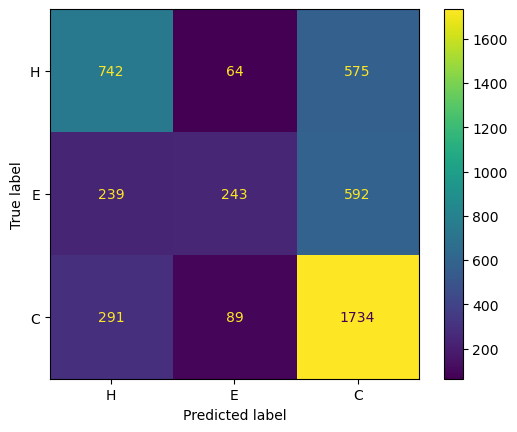

In [14]:
# predit test
y_pred = rf_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['H', 'E', 'C'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['H', 'E', 'C'])
disp.plot()

In [15]:
## K-fold Cross-validation
from sklearn.model_selection import cross_val_score

# 1. Define model
model = RandomForestClassifier(n_estimators=100, random_state=42)

## 2. Define K-Fold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Evaluate using cross_val_score (for accuracy)
scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# 4. Print results

print(f"Cross-validation Accuracies: {scores}")
print(f'Mean Accuracy: {np.mean(scores):.4f}')
print(f'Standard Deviation : {np.std(scores):.4f}')

Cross-validation Accuracies: [0.59662946 0.57977676 0.57049037 0.59632224 0.58559545]
Mean Accuracy: 0.5858
Standard Deviation : 0.0100


In [17]:
# Grid search
from sklearn.model_selection import GridSearchCV

# 1. Define base model
model = RandomForestClassifier(random_state=42)

# 2. Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],    # Number of trees
    'max_depth': [None, 10, 20,],      # Maximum depth of tree
    'min_samples_split':[2, 5],        # Min samples required to split
    'min_samples_leaf': [1, 2],        # Min samples at a leaf node
    'bootstrap': [True, False]          # Sampling method
    }

# 3. Set up GridSearchCV

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 4. Fit the grid search

grid_search.fit(X,y)

# 5. Print the best parameters and score

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.5954379701935568
